##  Please see final cell of code below for revisions to original notebook. 

Project Luther

Subject:      Predicting NBA salaries from player statistics

Date:         1/29/2018

Name:         Brian Kim

In [5]:
#Preprocessing 
import itertools
from sklearn import preprocessing
import re
from sklearn import feature_selection as f_select

import pandas as pd
import numpy as np
import pickle 
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
% matplotlib inline

import warnings
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
import sklearn.linear_model
import os
import math
import statsmodels.api as sm
import pylab as pl
from sklearn.metrics import roc_curve, auc
from __future__ import print_function, division

from sklearn.linear_model import RidgeCV





col_names = ['name', 'team', 'salary' ]
dfs = pd.read_csv('nba_salaries.csv', header=None, names = col_names)
dfp = pd.read_csv("nba_stats_2016.csv")



col_names = ['name', 'team', 'salary' ]
dfs = pd.read_csv('nba_salaries.csv', header=None, names = col_names)
dfp = pd.read_csv("nba_stats_2016.csv")


dfs = dfs.dropna(how='any')  



dfs[['name', 'position']] = dfs['name'].str.split(',\s+', expand=True)

dfs.salary = dfs.salary.replace({'\$': '', ',': ''}, regex=True)
dfs[pd.to_numeric(dfs['salary'], errors='coerce').notnull()]
dfs['player'] = dfs.name


dfs.salary = pd.to_numeric(dfs.salary, errors='coerce').dropna()
dfs = dfs.dropna(how='any')  
dfs.dtypes


#groupby player and sum total games played for all teams on which he played
dfp['total_g'] = dfp['G'].groupby(dfp['Player']).transform('sum')

df1 = dfs.merge(dfp, left_on = 'name', right_on = "Player", how = 'left')


df3 = df1[['name','salary', 'Age' ,'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PS/G']].copy()
df3 = df3.rename(columns={'FG%': 'FG_PCT', '3P%': '3P_PCT', \
'2P%': '2P_PCT', 'eFG%': 'eFG_PCT', 'FT%':"FT_PCT", 'PS/G': 'PS_G'})









df3=df3.rename(columns={'3P': "THREE_P", '3PA': 'THREE_PA', '3P_PCT': 'THREE_P_PCT', '2P': "TWO_P",\
                    '2PA':'TWO_PA', '2P_PCT': "TWO_P_PCT", 'PS/G': 'PS_G'})


df3.fillna(0, inplace=True)
df3.isnull().sum()


name           0
salary         0
Age            0
G              0
GS             0
MP             0
FG             0
FGA            0
FG_PCT         0
THREE_P        0
THREE_PA       0
THREE_P_PCT    0
TWO_P          0
TWO_PA         0
TWO_P_PCT      0
eFG_PCT        0
FT             0
FTA            0
FT_PCT         0
ORB            0
DRB            0
TRB            0
AST            0
STL            0
BLK            0
TOV            0
PF             0
PS_G           0
dtype: int64

## Prepocessing above
## Modeling below

Rk -- Rank Pos -- Position Age -- Age of Player at the start of February 1st of that season. Tm -- Team G -- Games GS -- Games Started MP -- Minutes Played Per Game FG -- Field Goals Per Game FGA -- Field Goal Attempts Per Game FG% -- Field Goal Percentage 3P -- 3-Point Field Goals Per Game 3PA -- 3-Point Field Goal Attempts Per Game 3P% -- FG% on 3-Pt FGAs. 2P -- 2-Point Field Goals Per Game 2PA -- 2-Point Field Goal Attempts Per Game 2P% -- FG% on 2-Pt FGAs. eFG% -- Effective Field Goal Percentage This statistic adjusts for the fact that a 3-point field goal is worth one more point than a 2-point field goal. FT -- Free Throws Per Game FTA -- Free Throw Attempts Per Game FT% -- Free Throw Percentage ORB -- Offensive Rebounds Per Game DRB -- Defensive Rebounds Per Game TRB -- Total Rebounds Per Game AST -- Assists Per Game STL -- Steals Per Game BLK -- Blocks Per Game TOV -- Turnovers Per Game PF -- Personal Fouls Per Game PS/G -- Points Per Game

In [6]:
df3['salary_log']= np.log(df3.salary)



In [7]:
df3.describe()

,salary,Age,G,GS,MP,FG,FGA,FG_PCT,THREE_P,THREE_PA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PS_G,salary_log
count,4.920000e+02,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,...,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000
mean,5.696975e+06,20.365854,43.709350,21.707317,16.869106,2.639024,5.878049,0.345652,0.572561,1.629065,...,0.700407,2.283740,2.981707,1.592683,0.540854,0.338821,0.965854,1.416057,7.023171,14.805236
std,6.029553e+06,11.653880,31.191395,28.541314,11.954115,2.253827,4.919180,0.201824,0.684539,1.807393,...,0.762646,1.933429,2.592059,1.800143,0.477282,0.419117,0.850717,0.993342,6.076839,1.506301
min,5.767000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.659907
25%,1.187340e+06,20.000000,6.000000,0.000000,5.550000,0.575000,1.375000,0.317500,0.000000,0.000000,...,0.100000,0.675000,0.900000,0.100000,0.100000,0.000000,0.175000,0.475000,1.300000,13.987224
50%,3.333334e+06,24.000000,53.000000,4.000000,18.100000,2.400000,5.300000,0.423000,0.300000,1.100000,...,0.500000,2.100000,2.600000,1.100000,0.500000,0.200000,0.900000,1.600000,6.300000,15.019483
75%,8.072972e+06,28.000000,73.250000,41.500000,27.225000,4.125000,9.200000,0.467000,1.000000,2.900000,...,1.100000,3.400000,4.400000,2.200000,0.800000,0.500000,1.400000,2.200000,10.900000,15.904032
max,3.096345e+07,39.000000,82.000000,82.000000,42.000000,10.200000,20.500000,1.000000,5.100000,11.200000,...,3.500000,9.100000,11.800000,11.700000,2.100000,2.200000,4.100000,6.000000,30.100000,17.248318


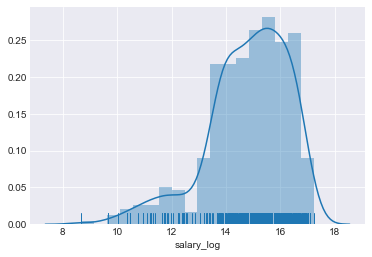

In [8]:
ax = sns.distplot(df3.salary_log, rug=True)  
plt.savefig('fig1')

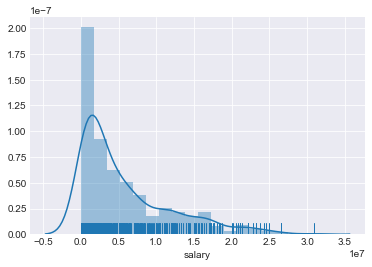

In [9]:
ax = sns.distplot(df3.salary, rug=True)  
plt.savefig('fig1')

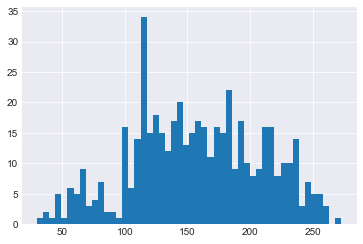

In [10]:
from scipy import stats
import numpy as np

# get values from our "AIR_TIME" column
salary_bx = np.asarray(df3[['salary']].values)

# transform values and store as "dft"
sal_bx_vals = stats.boxcox(salary_bx)[0]
df3['salary_bx'] = stats.boxcox(salary_bx)[0]
# plot the transformed data

plt.hist(sal_bx_vals, bins=50
        )


plt.savefig('sal_bx.png')

In [11]:
df3.head()

,name,salary,Age,G,GS,MP,FG,FGA,FG_PCT,THREE_P,...,DRB,TRB,AST,STL,BLK,TOV,PF,PS_G,salary_log,salary_bx
0,LeBron James,30963450.0,31.0,76.0,76.0,35.6,9.7,18.6,0.520,1.1,...,6.0,7.4,6.8,1.4,0.6,3.3,1.9,25.3,17.248318,272.986339
1,Mike Conley,26540100.0,28.0,56.0,56.0,31.4,5.3,12.4,0.422,1.4,...,2.5,2.9,6.1,1.2,0.3,1.5,1.8,15.3,17.094167,262.742201
2,Al Horford,26540100.0,29.0,82.0,82.0,32.1,6.5,12.8,0.505,1.1,...,5.5,7.3,3.2,0.8,1.5,1.3,2.0,15.2,17.094167,262.742201
3,Dirk Nowitzki,25000000.0,37.0,75.0,75.0,31.5,6.6,14.8,0.448,1.7,...,5.8,6.5,1.8,0.7,0.7,1.1,2.1,18.3,17.034386,258.872138
4,Carmelo Anthony,24559380.0,31.0,72.0,72.0,35.1,7.9,18.2,0.434,1.5,...,6.4,7.7,4.2,0.9,0.5,2.4,2.5,21.8,17.016604,257.731848


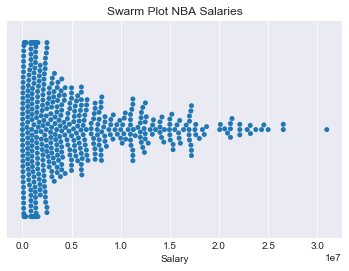

In [12]:
sns.set_style("darkgrid")
ax=sns.swarmplot(df3.salary)
ax.set(xlabel='Salary', 
       title='Swarm Plot NBA Salaries')

plt.legend();

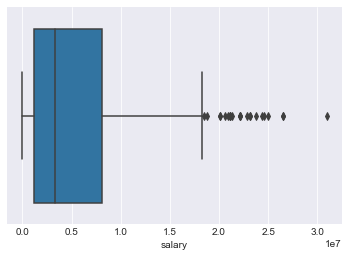

In [13]:
sns.boxplot(df3.salary,whis=1.5)

plt.savefig('salaryboxplot.png') 

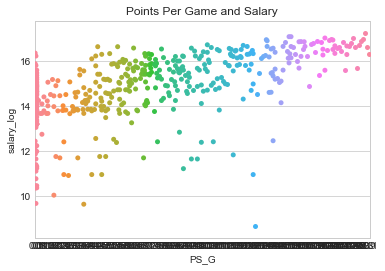

In [14]:
sns.set_style("whitegrid")
ax=sns.swarmplot(x = df3.PS_G, y = df3.salary_log)
ax.set(title='Points Per Game and Salary')

plt.legend();

In [15]:
lm1 = smf.ols('salary_log ~ MP +PS_G\
               +FT_PCT + Age+GS', data=df3)
# Fit the model
fit1 = lm1.fit()
# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             salary_log   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     53.54
Date:                Wed, 31 Jan 2018   Prob (F-statistic):           3.03e-44
Time:                        16:21:51   Log-Likelihood:                -791.23
No. Observations:                 492   AIC:                             1594.
Df Residuals:                     486   BIC:                             1620.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.6441      0.112    122.307      0.000      13.425      13.863
MP            -0.0078      0.016     -0.483      0.629      -0.039       0.024
PS_G           0.1194      0.024      4.909      0.000       0.072       0.167
FT_PCT        -0.2100      0.386     -0.544      0.587      -0.969       0.549
Age            0.0212      0.011      1.968      0.050    3.06e-05       0.042
GS             0.0065      0.003      2.046      0.041       0.000       0.013
==============================================================================
Omnibus:                      159.800   Durbin-Watson:                   0.524
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              498.108
Skew:                          -1.528   Prob(JB):                    6.87e-109
Kurtosis:                       6.868   Cond. No.                         320.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
#df3.corr()['salary_l'].sort_values(ascending=False)

In [17]:
lm1 = smf.ols('salary_bx ~PS_G\
               +FT_PCT + Age', data=df3)
# Fit the model
fit1 = lm1.fit()
# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              salary_bx   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     134.6
Date:                Wed, 31 Jan 2018   Prob (F-statistic):           1.48e-63
Time:                        16:21:51   Log-Likelihood:                -2488.4
No. Observations:                 492   AIC:                             4985.
Df Residuals:                     488   BIC:                             5002.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    115.5885      3.502     33.004      0.000     108.707     122.470
PS_G           5.6445      0.388     14.545      0.000       4.882       6.407
FT_PCT       -27.2506     11.867     -2.296      0.022     -50.566      -3.935
Age            0.8829      0.316      2.793      0.005       0.262       1.504
==============================================================================
Omnibus:                       52.721   Durbin-Watson:                   0.778
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.119
Skew:                          -0.695   Prob(JB):                     1.99e-19
Kurtosis:                       4.506   Cond. No.                         171.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
lm_3 = smf.ols('salary_bx ~ Age+G+GS+MP+FG+FGA+FG_PCT+THREE_P+\
THREE_PA+THREE_P_PCT+TWO_P+TWO_PA+TWO_P_PCT+eFG_PCT+FT+FTA+FT_PCT\
+ORB+DRB+TRB+AST+STL+BLK+TOV+PF+PS_G',data = df3)
# Fit the model
fit_3= lm_3.fit()
# Print summary statistics of the model's performance
fit_3.summary()




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              salary_bx   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     20.14
Date:                Wed, 31 Jan 2018   Prob (F-statistic):           2.55e-60
Time:                        16:21:51   Log-Likelihood:                -2451.2
No. Observations:                 492   AIC:                             4956.
Df Residuals:                     465   BIC:                             5070.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     118.1556      3.394     34.818      0.000     111.487     124.824
Age             1.9199      0.450      4.268      0.000       1.036       2.804
G               0.3552      0.111      3.212      0.001       0.138       0.573
GS             -0.1106      0.109     -1.011      0.312      -0.326       0.104
MP              1.5697      0.706      2.222      0.027       0.182       2.958
FG            -22.1835     61.370     -0.361      0.718    -142.780      98.413
FGA            38.1786     42.589      0.896      0.370     -45.513     121.870
FG_PCT        -71.7294    142.663     -0.503      0.615    -352.072     208.614
THREE_P       -43.2837     53.049     -0.816      0.415    -147.529      60.962
THREE_PA      -50.4571     42.067     -1.199      0.231    -133.121      32.207
THREE_P_PCT   -34.7444     19.727     -1.761      0.079     -73.509       4.020
TWO_P         -23.6358     43.096     -0.548      0.584    -108.324      61.052
TWO_PA        -49.0493     42.934     -1.142      0.254    -133.418      35.319
TWO_P_PCT      33.5887     58.161      0.578      0.564     -80.702     147.879
eFG_PCT       -48.2899    118.302     -0.408      0.683    -280.762     184.182
FT            -24.4582     27.799     -0.880      0.379     -79.086      30.170
FTA            -5.4893      8.846     -0.621      0.535     -22.872      11.893
FT_PCT        -24.6351     14.459     -1.704      0.089     -53.049       3.779
ORB            33.2073     37.919      0.876      0.382     -41.306     107.720
DRB            27.7636     38.101      0.729      0.467     -47.108     102.635
TRB           -24.0822     38.032     -0.633      0.527     -98.817      50.653
AST             1.1993      2.353      0.510      0.611      -3.425       5.823
STL            -4.0864      7.340     -0.557      0.578     -18.511      10.338
BLK            -2.0458      7.178     -0.285      0.776     -16.152      12.060
TOV            -2.0783      6.931     -0.300      0.764     -15.699      11.542
PF            -17.0808      4.718     -3.620      0.000     -26.352      -7.810
PS_G           37.1841     25.785      1.442      0.150     -13.486      87.854
==============================================================================
Omnibus:                       36.907   Durbin-Watson:                   0.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.510
Skew:                          -0.582   Prob(JB):                     1.08e-11
Kurtosis:                       4.053   Cond. No.                     7.82e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.82e+03. This might indicate that there are
strong multicollinearity o

In [19]:
df3.shape

(492, 30)

In [20]:
X =df3.iloc[:,3:25]
y= df3.iloc[:,29]


In [21]:

lr = LinearRegression()
# INSTRUCTOR NOTE: Run this multiple times to show the variation
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# Fit the model against the training data
lr.fit(X_train, y_train)
# Evaluate the model against the testing data
lr.score(X_test, y_test)

0.39313544202028072

In [22]:
from sklearn.cross_validation import cross_val_score

reg = LinearRegression()
scores = cross_val_score(reg, X, y, cv=10, scoring='r2')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print(scores)


[-21.91876382 -77.81449695 -40.15629648 -76.36186083 -39.98180271
 -55.50534172 -31.88129181 -42.18273678 -10.28833926 -36.61898295]


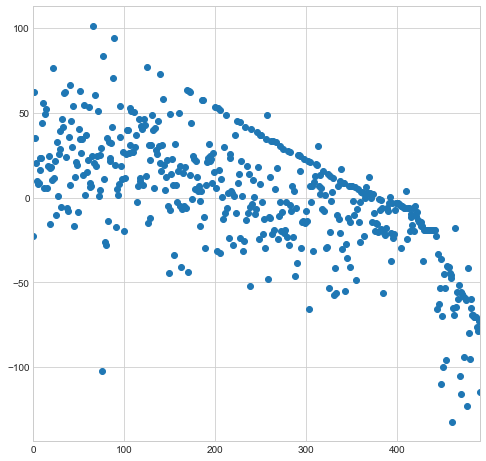

In [23]:
fit_3.resid.plot(style='o', figsize=(8,8))
plt.savefig('resplot.png')

In [24]:
est=LinearRegression()

kf=KFold(n=len(X),n_folds=5,shuffle=True)

all_scores=[]

# Instead of using cross_val_score, let's use sklearn.cross_validation.KFold; this will allow
# us to 'manipulate' our training set, 


# get indices of corresponding train & test
for train,test in kf:
    x_train=X.iloc[train]
    y_train=y.iloc[train]
    x_test=X.iloc[test]
    y_test=y.iloc[test]
    pvals=[]
    sig_cols=[]
    
    for feature in x_train.columns:
        pval=f_select.f_regression(x_train[[feature]],y_train)
        if pval[1][0]<.02: 
            sig_cols.append(feature)
            pvals.append(pval[1][0])
            
    est.fit(x_train[sig_cols],y_train)
    r_2=est.score(x_test[sig_cols],y_test)
    all_scores.append(r_2)
        
np.mean(all_scores)
    

0.42094961434169831

In [25]:
###Cut outliers
len(df3)

492

In [26]:
df5 = df3[:-49]

In [27]:
len(df5
   )

443

In [28]:
df5.tail()

,name,salary,Age,G,GS,MP,FG,FGA,FG_PCT,THREE_P,...,DRB,TRB,AST,STL,BLK,TOV,PF,PS_G,salary_log,salary_bx
438,Thomas Walkup,543471.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.205732,99.073624
439,Diamond Stone,543471.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.205732,99.073624
440,Nicolas Brussino,543471.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.205732,99.073624
441,Jonathan Holmes,543471.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.205732,99.073624
442,Richard Solomon,543471.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.205732,99.073624


In [29]:
X =df5.iloc[:,3:25]
y= df5.iloc[:,29]


In [30]:
lm_5 = smf.ols('salary_bx ~ Age+G+GS+MP+FG+FGA+FG_PCT+THREE_P+\
THREE_PA+THREE_P_PCT+TWO_P+TWO_PA+TWO_P_PCT+eFG_PCT+FT+FTA+FT_PCT\
+ORB+DRB+TRB+AST+STL+BLK+TOV+PF+PS_G',data = df5)
# Fit the model
fit_5= lm_5.fit()
# Print summary statistics of the model's performance
fit_5.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              salary_bx   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     28.66
Date:                Wed, 31 Jan 2018   Prob (F-statistic):           1.91e-76
Time:                        16:22:01   Log-Likelihood:                -2070.0
No. Observations:                 443   AIC:                             4194.
Df Residuals:                     416   BIC:                             4305.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     130.8328      2.768     47.266      0.000     125.392     136.274
Age             2.1049      0.346      6.077      0.000       1.424       2.786
G               0.1036      0.086      1.198      0.232      -0.066       0.274
GS             -0.1366      0.084     -1.627      0.104      -0.302       0.028
MP              2.4939      0.553      4.507      0.000       1.406       3.582
FG             -3.3303     47.081     -0.071      0.944     -95.877      89.217
FGA            26.4341     32.110      0.823      0.411     -36.684      89.552
FG_PCT         12.8426    114.889      0.112      0.911    -212.993     238.678
THREE_P       -16.9355     40.169     -0.422      0.674     -95.895      62.024
THREE_PA      -32.5761     31.826     -1.024      0.307     -95.135      29.983
THREE_P_PCT   -24.6989     17.276     -1.430      0.154     -58.659       9.261
TWO_P          -6.0467     32.971     -0.183      0.855     -70.858      58.764
TWO_PA        -35.6239     32.415     -1.099      0.272     -99.342      28.094
TWO_P_PCT     -13.4154     56.483     -0.238      0.812    -124.443      97.612
eFG_PCT       -94.9643    100.366     -0.946      0.345    -292.253     102.324
FT              3.2172     21.350      0.151      0.880     -38.751      45.186
FTA           -12.3850      6.749     -1.835      0.067     -25.652       0.882
FT_PCT        -42.2778     12.475     -3.389      0.001     -66.799     -17.757
ORB            15.4406     28.653      0.539      0.590     -40.883      71.764
DRB            20.2739     28.776      0.705      0.481     -36.291      76.839
TRB           -15.2103     28.746     -0.529      0.597     -71.715      41.295
AST             3.9777      1.783      2.231      0.026       0.472       7.483
STL            -8.8766      5.694     -1.559      0.120     -20.070       2.317
BLK             2.2854      5.604      0.408      0.684      -8.730      13.301
TOV           -13.7272      5.419     -2.533      0.012     -24.379      -3.076
PF             -2.9863      3.934     -0.759      0.448     -10.719       4.746
PS_G           16.2141     19.835      0.817      0.414     -22.775      55.203
==============================================================================
Omnibus:                        3.049   Durbin-Watson:                   1.309
Prob(Omnibus):                  0.218   Jarque-Bera (JB):                2.862
Skew:                           0.192   Prob(JB):                        0.239
Kurtosis:                       3.086   Cond. No.                     8.39e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.39e+03. This might indicate that there are
strong multicollinearity o

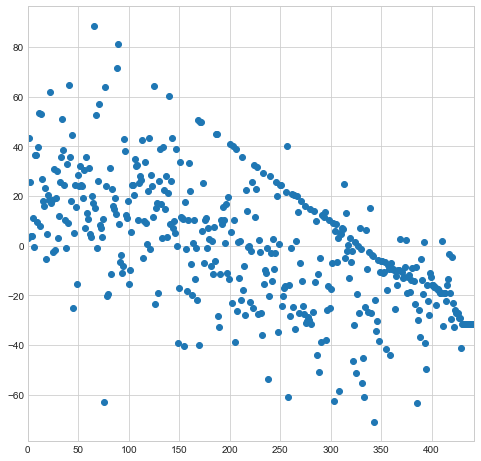

In [31]:
fit_5.resid.plot(style='o', figsize=(8,8))
plt.savefig('resplot.png')

In [32]:
lr = LinearRegression()
# INSTRUCTOR NOTE: Run this multiple times to show the variation
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# Fit the model against the training data
lr.fit(X_train, y_train)
# Evaluate the model against the testing data
lr.score(X_test, y_test)

0.5679895330847885

In [33]:
reg = LinearRegression()
scores = cross_val_score(reg, X, y, cv=10, scoring='r2')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print(scores)


[ -19.59105631  -48.35328435  -20.16846225  -49.3636842   -28.16066164
  -62.92639146 -102.57253586  -53.95247445 -122.97177512  -36.61305353]


In [34]:
##drop top 20 
df7 = df5[19:]

In [35]:
len(df7)

424

In [36]:
len(df5)

443

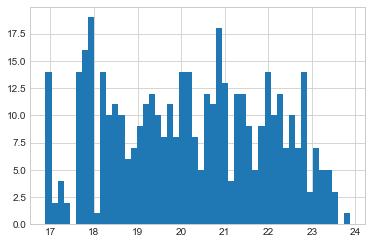

In [40]:
salary_bx = np.asarray(df5[['salary']].values)

# transform values and store as "dft"
sal_bx_vals = stats.boxcox(salary_bx)[0]
df5['salary_bx'] = stats.boxcox(salary_bx)[0]
# plot the transformed data

plt.hist(sal_bx_vals, bins=50
        )
plt.show()

In [41]:
X =df7.iloc[:,3:25]
y= df7.iloc[:,29]


In [51]:

lr = LinearRegression()
# INSTRUCTOR NOTE: Run this multiple times to show the variation
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# Fit the model against the training data
lr.fit(X_train, y_train)
# Evaluate the model against the testing data
lr.score(X_test, y_test)

0.48815989156290879

In [52]:
reg = LinearRegression()
scores = cross_val_score(reg, X, y, cv=10, scoring='r2')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print(scores)


[ -81.11367025 -118.88052188  -57.1775241   -81.17214958  -34.734791
  -56.61940142  -68.18130974  -54.55833701 -113.86150942  -27.31403098]


In [44]:
##just for kicks
## field goal attempts per game had a coeff of .99
lm_9 = smf.ols('salary_bx ~ FGA',data = df5)
# Fit the model
fit_9= lm_9.fit()
# Print summary statistics of the model's performance
fit_9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              salary_bx   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     423.3
Date:                Wed, 31 Jan 2018   Prob (F-statistic):           1.97e-66
Time:                        16:22:32   Log-Likelihood:                -737.70
No. Observations:                 443   AIC:                             1479.
Df Residuals:                     441   BIC:                             1488.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.6221      0.097    191.063      0.000      18.430      18.814
FGA            0.2541      0.012     20.575      0.000       0.230       0.278
==============================================================================
Omnibus:                       11.983   Durbin-Watson:                   0.960
Prob(Omnibus):                  0.002   Jarque-Bera (JB):                6.733
Skew:                           0.096   Prob(JB):                       0.0345
Kurtosis:                       2.428   Cond. No.                         12.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Changes from original notebook are below.
#### Recap: all R-squareds using "cross_val_score" above repeatedly came up negative.
 As discussed, the above code received a score of 2 because manual calculation of R-squared was not implemented.  It is implemented in the cell below. 


In [56]:
est=LinearRegression()

kf=KFold(n=len(X),n_folds=5,shuffle=True)

all_scores=[]

for train,test in kf:
    x_train=X.iloc[train]
    y_train=y.iloc[train]
    x_test=X.iloc[test]
    y_test=y.iloc[test]
    pvals=[]
    sig_cols=[]
    
    for feature in x_train.columns:
        pval=f_select.f_regression(x_train[[feature]],y_train)
        if pval[1][0]<.02: 
            sig_cols.append(feature)
            pvals.append(pval[1][0])
            
    est.fit(x_train[sig_cols],y_train)
    r_2=est.score(x_test[sig_cols],y_test)
    all_scores.append(r_2)
        
np.mean(all_scores)
    

0.47217019480899697

#### R-squared above is positive and consistent with Linear Regression score.

